After conducting previous experiments, which included training models without spatial lag features, and experimenting with different spatial lag models, the **XGBoost** model with **spatial lag** features created using **distance band with value 10000** emerged as the best-performing model, achieving an F1 score of **77.0%%**. Therefore, to address SQ2, this specific model is explored in this notebook using imblance techniques (**Random oversampling, Random undersampling and Smote-Tomek**).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import geopandas as gpd
import torch
import joblib
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score,confusion_matrix, classification_report
np.random.seed(10)
from libpysal import weights
from functions_spatialmodels import Objective_knn, Objective_rf, Objective_xgb, Objective_tabnet, all_metrics, predict, conf_matrix
from functions_spatialmodels import spatial_lag_distance_band, spatial_lag_knn, spatial_lag_queen, spatial_lag_rook, encoding_categorical_features, scaling_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
X_train_distance_band10000 = np.load('X_train_distance_band10000.npy')
X_test_distance_band10000 = np.load('X_test_distance_band10000.npy')
X_val_distance_band10000 = np.load('X_val_distance_band10000.npy')


all_feature_dist10000 = np.load('all_feature_dist10000.npy', allow_pickle=True)
all_feature_dist10000= all_feature_dist10000.tolist()


In [6]:
len(all_feature_dist10000)

41

In [7]:
# load the y_data (encoded)
y_train_split = np.loadtxt('y_train_split_encoded.txt', dtype=int)
y_val = np.loadtxt('y_val_encoded.txt', dtype=int)
y_test = np.loadtxt('y_test_encoded.txt', dtype=int)

In [8]:
import optuna
from optuna import Trial
from sklearn.metrics import f1_score, accuracy_score
random_state = 0

from sklearn.metrics import f1_score
import optuna
from optuna.pruners import SuccessiveHalvingPruner

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

# Undersampling

In [11]:
def Objective_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_child_weight = trial.suggest_float("min_child_weight", 0.1, 200.0)
    gamma = trial.suggest_float("gamma", 0.0, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 30.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 30.0)

    xgb_opt = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=0, objective='multi:softmax', num_class=5)
    
    # Random undersampling
    rus = RandomUnderSampler(random_state=0)
    X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_distance_band10000, y_train_split)
    
    xgb_opt.fit(X_train_undersampled, y_train_undersampled)
    
    y_pred_val_pred = xgb_opt.predict(X_val_distance_band10000)  
 
    f1_macro = f1_score(y_val, y_pred_val_pred, average='macro') 

    return f1_macro


In [12]:
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study_rus_xgb = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=random_state), pruner=pruner)
study_rus_xgb.optimize(Objective_xgb, n_trials=10)
joblib.dump(study_rus_xgb, 'study_xgb_undersampling.pkl')


trial = study_rus_xgb.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 19:23:20,399] A new study created in memory with name: no-name-9e54f156-fdd6-4559-a75f-44eba9489523
[I 2024-04-28 19:23:29,468] Trial 0 finished with value: 0.7669980952578481 and parameters: {'learning_rate': 0.12520653814999466, 'n_estimators': 744, 'max_depth': 19, 'min_child_weight': 109.02214828107968, 'gamma': 0.4236547993389047, 'subsample': 0.8229470565333281, 'colsample_bytree': 0.7187936056313462, 'reg_alpha': 26.753190023462395, 'reg_lambda': 28.90988281503088}. Best is trial 0 with value: 0.7669980952578481.
[I 2024-04-28 19:23:46,165] Trial 1 finished with value: 0.7670112140935934 and parameters: {'learning_rate': 0.058463261216434144, 'n_estimators': 813, 'max_depth': 17, 'min_child_weight': 113.65210776267706, 'gamma': 0.925596638292661, 'subsample': 0.5355180290989434, 'colsample_bytree': 0.5435646498507704, 'reg_alpha': 0.6065519232097716, 'reg_lambda': 24.97859536643814}. Best is trial 1 with value: 0.7670112140935934.
[I 2024-04-28 19:23:54,627] Trial 

Best Score:  0.7670112140935934
Best Params: 
  learning_rate: 0.058463261216434144
  n_estimators: 813
  max_depth: 17
  min_child_weight: 113.65210776267706
  gamma: 0.925596638292661
  subsample: 0.5355180290989434
  colsample_bytree: 0.5435646498507704
  reg_alpha: 0.6065519232097716
  reg_lambda: 24.97859536643814


In [13]:
xgb_und = joblib.load('study_xgb_undersampling.pkl')
xgb_und.best_params

{'learning_rate': 0.058463261216434144,
 'n_estimators': 813,
 'max_depth': 17,
 'min_child_weight': 113.65210776267706,
 'gamma': 0.925596638292661,
 'subsample': 0.5355180290989434,
 'colsample_bytree': 0.5435646498507704,
 'reg_alpha': 0.6065519232097716,
 'reg_lambda': 24.97859536643814}

In [14]:
# fit the model
rus = RandomUnderSampler(random_state=0)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_distance_band10000, y_train_split)

In [16]:
import xgboost as xgb
y_pred_und_xgb, y_pred_prob_und_xgb = predict(
    classifier=xgb.XGBClassifier,
    params=xgb_und.best_params,
    X_train=X_train_undersampled,
    y_train=y_train_undersampled,
    X_test=X_test_distance_band10000
)

In [17]:
metrics_xgboost_und = all_metrics(y_test, y_pred_und_xgb, y_pred_prob_und_xgb, "XGBoost_Undersampling")

metrics_xgboost_und.to_csv("metrics_xgboost_und.csv")

# Display the metrics
metrics_xgboost_und

,XGBoost_Undersampling
Precision (Macro),74.35%
Recall (Macro),77.04%
F1-score (Macro),75.33%
Balanced Accuracy,77.04%
Log Loss,0.604246


# Oversampling

In [23]:
# part of this code is adopted from : 
# https://medium.com/@mlxl/knime-xgboost-and-optuna-for-hyper-parameter-optimization-dcf0efdc8ddf
def Objective_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
    n_estimators = trial.suggest_int("n_estimators", 200, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_child_weight = trial.suggest_float("min_child_weight", 0.1, 200.0)
    gamma = trial.suggest_float("gamma", 0.0, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 30.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 30.0)

    xgb_opt = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=0, objective='multi:softmax', num_class=5)
    
    # Random oversampling
    ros = RandomOverSampler(random_state=0)
    X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train_distance_band10000, y_train_split)
    
    xgb_opt.fit(X_train_oversampled, y_train_oversampled)
    
    y_pred_val_pred = xgb_opt.predict(X_val_distance_band10000)  
 
    f1_macro = f1_score(y_val, y_pred_val_pred, average='macro') 

    return f1_macro

In [24]:
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study_rus_xgb = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=random_state), pruner=pruner)
study_rus_xgb.optimize(Objective_xgb, n_trials=10)
joblib.dump(study_rus_xgb, 'study_xgb_oversampling.pkl')


trial = study_rus_xgb.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 19:30:22,163] A new study created in memory with name: no-name-4fd98ce1-c1bf-41d5-9b95-2d4bd2205450
[I 2024-04-28 19:30:40,931] Trial 0 finished with value: 0.7779023489737094 and parameters: {'learning_rate': 0.12520653814999466, 'n_estimators': 272, 'max_depth': 19, 'min_child_weight': 109.02214828107968, 'gamma': 0.4236547993389047, 'subsample': 0.8229470565333281, 'colsample_bytree': 0.7187936056313462, 'reg_alpha': 26.753190023462395, 'reg_lambda': 28.90988281503088}. Best is trial 0 with value: 0.7779023489737094.
[I 2024-04-28 19:31:01,977] Trial 1 finished with value: 0.7760372096336905 and parameters: {'learning_rate': 0.058463261216434144, 'n_estimators': 279, 'max_depth': 17, 'min_child_weight': 113.65210776267706, 'gamma': 0.925596638292661, 'subsample': 0.5355180290989434, 'colsample_bytree': 0.5435646498507704, 'reg_alpha': 0.6065519232097716, 'reg_lambda': 24.97859536643814}. Best is trial 0 with value: 0.7779023489737094.
[I 2024-04-28 19:31:19,550] Trial 

Best Score:  0.7779023489737094
Best Params: 
  learning_rate: 0.12520653814999466
  n_estimators: 272
  max_depth: 19
  min_child_weight: 109.02214828107968
  gamma: 0.4236547993389047
  subsample: 0.8229470565333281
  colsample_bytree: 0.7187936056313462
  reg_alpha: 26.753190023462395
  reg_lambda: 28.90988281503088


In [25]:
xgb_over = joblib.load('study_xgb_oversampling.pkl')
xgb_over.best_params

{'learning_rate': 0.12520653814999466,
 'n_estimators': 272,
 'max_depth': 19,
 'min_child_weight': 109.02214828107968,
 'gamma': 0.4236547993389047,
 'subsample': 0.8229470565333281,
 'colsample_bytree': 0.7187936056313462,
 'reg_alpha': 26.753190023462395,
 'reg_lambda': 28.90988281503088}

In [26]:
# fit the model
ros = RandomOverSampler(random_state=0)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train_distance_band10000, y_train_split)

In [29]:
import xgboost as xgb

y_pred_over_xgb, y_pred_prob_over_xgb = predict(
    classifier=xgb.XGBClassifier,
    params=xgb_over.best_params,
    X_train=X_train_oversampled,
    y_train=y_train_oversampled,
    X_test=X_test_distance_band10000)

In [30]:
metrics_xgboost_over = all_metrics(y_test, y_pred_over_xgb, y_pred_prob_over_xgb, "XGBoost_Oversampling")
metrics_xgboost_over.to_csv("metrics_xgboost_over.csv")
metrics_xgboost_over

,XGBoost_Oversampling
Precision (Macro),75.82%
Recall (Macro),77.39%
F1-score (Macro),76.5%
Balanced Accuracy,77.39%
Log Loss,0.569152


# SMOTE-Tomek

In [31]:
# part of this code is adopted from : 
# https://medium.com/@mlxl/knime-xgboost-and-optuna-for-hyper-parameter-optimization-dcf0efdc8ddf
def Objective_xgb(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
    n_estimators = trial.suggest_int("n_estimators", 200, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_child_weight = trial.suggest_float("min_child_weight", 0.1, 200.0)
    gamma = trial.suggest_float("gamma", 0.0, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 30.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 30.0)

    xgb_opt = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=0, objective='multi:softmax', num_class=5)
    
    # SMOTE
    smt = SMOTETomek(random_state=0, n_jobs=-1)
    X_smote, y_smote = smt.fit_resample(X_train_distance_band10000, y_train_split)
    
    xgb_opt.fit(X_smote, y_smote)
    
    y_pred_val_pred = xgb_opt.predict(X_val_distance_band10000)  
 
    f1_macro = f1_score(y_val, y_pred_val_pred, average='macro') 

    return f1_macro


In [32]:
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study_smt_xgb = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=random_state), pruner=pruner)
study_smt_xgb.optimize(Objective_xgb, n_trials=10)
joblib.dump(study_smt_xgb, 'study_xgb_smote.pkl')


trial = study_smt_xgb.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 19:37:16,148] A new study created in memory with name: no-name-1da5c221-6631-4c5c-81cf-6af1f0c552ee
[I 2024-04-28 19:38:02,408] Trial 0 finished with value: 0.7810865011371404 and parameters: {'learning_rate': 0.12520653814999466, 'n_estimators': 272, 'max_depth': 19, 'min_child_weight': 109.02214828107968, 'gamma': 0.4236547993389047, 'subsample': 0.8229470565333281, 'colsample_bytree': 0.7187936056313462, 'reg_alpha': 26.753190023462395, 'reg_lambda': 28.90988281503088}. Best is trial 0 with value: 0.7810865011371404.
[I 2024-04-28 19:38:47,553] Trial 1 finished with value: 0.7794705093359806 and parameters: {'learning_rate': 0.058463261216434144, 'n_estimators': 279, 'max_depth': 17, 'min_child_weight': 113.65210776267706, 'gamma': 0.925596638292661, 'subsample': 0.5355180290989434, 'colsample_bytree': 0.5435646498507704, 'reg_alpha': 0.6065519232097716, 'reg_lambda': 24.97859536643814}. Best is trial 0 with value: 0.7810865011371404.
[I 2024-04-28 19:39:29,315] Trial 

Best Score:  0.7810865011371404
Best Params: 
  learning_rate: 0.12520653814999466
  n_estimators: 272
  max_depth: 19
  min_child_weight: 109.02214828107968
  gamma: 0.4236547993389047
  subsample: 0.8229470565333281
  colsample_bytree: 0.7187936056313462
  reg_alpha: 26.753190023462395
  reg_lambda: 28.90988281503088


In [34]:
xgb_smt= joblib.load('study_xgb_smote.pkl')
xgb_smt.best_params

{'learning_rate': 0.12520653814999466,
 'n_estimators': 272,
 'max_depth': 19,
 'min_child_weight': 109.02214828107968,
 'gamma': 0.4236547993389047,
 'subsample': 0.8229470565333281,
 'colsample_bytree': 0.7187936056313462,
 'reg_alpha': 26.753190023462395,
 'reg_lambda': 28.90988281503088}

In [35]:
# fit the model
rus_smt= SMOTETomek(random_state=0)
X_train_smt, y_train_smt = rus_smt.fit_resample(X_train_distance_band10000, y_train_split)

In [37]:
import xgboost as xgb
y_pred_smt_xgb, y_pred_prob_smt_xgb = predict(
    classifier=xgb.XGBClassifier,
    params=xgb_smt.best_params,
    X_train=X_train_smt,
    y_train=y_train_smt,
    X_test=X_test_distance_band10000)

In [38]:
metrics_xgboost_smt = all_metrics(y_test, y_pred_smt_xgb, y_pred_prob_smt_xgb, "XGBoost SMOTE Tomek")
metrics_xgboost_smt.to_csv("metrics_xgboost__smt.csv")
metrics_xgboost_smt


,XGBoost SMOTE Tomek
Precision (Macro),77.09%
Recall (Macro),76.42%
F1-score (Macro),76.69%
Balanced Accuracy,76.42%
Log Loss,0.553851


In [39]:
combined_metrics_df= pd.concat([metrics_xgboost_smt, metrics_xgboost_over, metrics_xgboost_und], axis=1)
combined_metrics_df

,XGBoost SMOTE Tomek,XGBoost_Oversampling,XGBoost_Undersampling
Precision (Macro),77.09%,75.82%,74.35%
Recall (Macro),76.42%,77.39%,77.04%
F1-score (Macro),76.69%,76.5%,75.33%
Balanced Accuracy,76.42%,77.39%,77.04%
Log Loss,0.553851,0.569152,0.604246


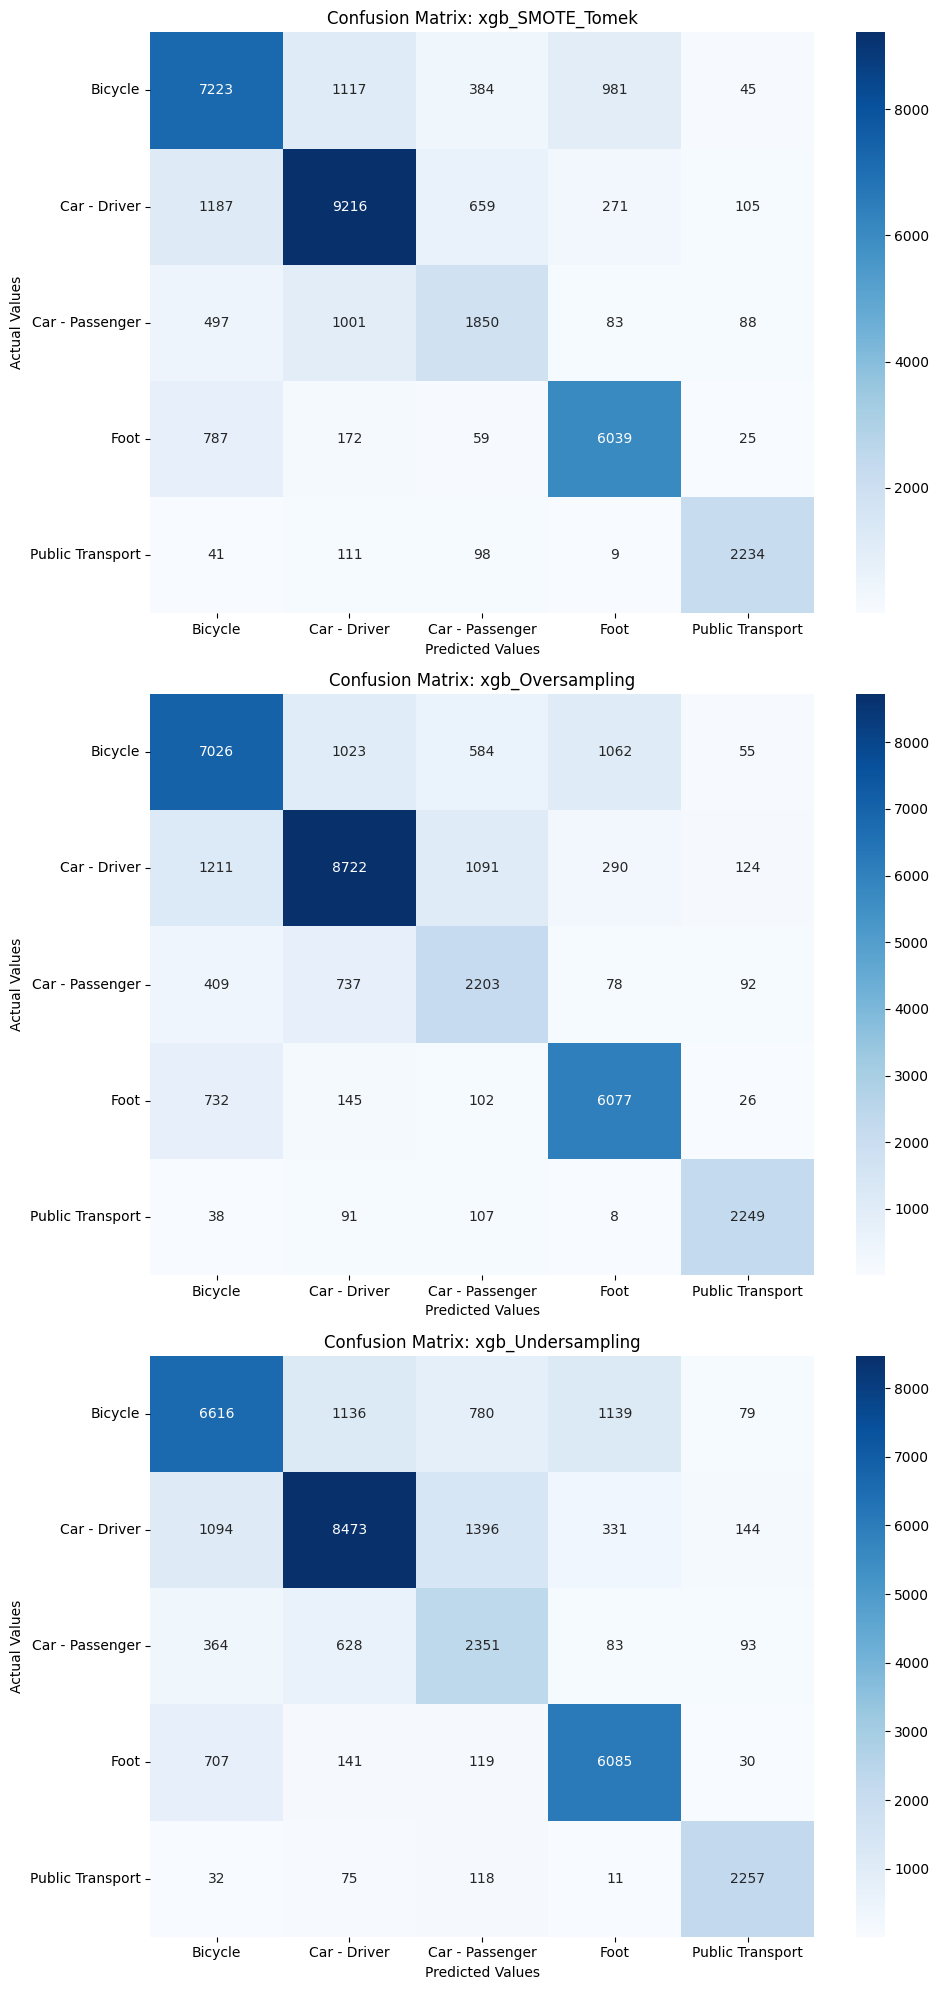

In [43]:
mapping = {'Bicycle': 0, 'Car - Driver': 1, 'Car - Passenger': 2, 'Foot': 3, 'Public Transport': 4}

def conf_matrix(y_true, y_pred, title, ax):
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=mapping.keys(), columns=mapping.keys())
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')

fig, axes = plt.subplots(3, 1, figsize=(10, 20)) 

conf_matrix(y_test, y_pred_smt_xgb, title="Confusion Matrix: xgb_SMOTE_Tomek", ax=axes[0])  
conf_matrix(y_test, y_pred_over_xgb, title="Confusion Matrix: xgb_Oversampling", ax=axes[1])  
conf_matrix(y_test, y_pred_und_xgb, title="Confusion Matrix: xgb_Undersampling", ax=axes[2])   

plt.tight_layout()  
plt.savefig("confusion_matrices_balancing.pdf")
plt.show()


In [44]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_xgb_Oversampling:")
print(classification_report(y_test, y_pred_over_xgb, target_names=list(mapping.keys())))

classification_report_xgb_Oversampling:
                  precision    recall  f1-score   support

         Bicycle       0.75      0.72      0.73      9750
    Car - Driver       0.81      0.76      0.79     11438
 Car - Passenger       0.54      0.63      0.58      3519
            Foot       0.81      0.86      0.83      7082
Public Transport       0.88      0.90      0.89      2493

        accuracy                           0.77     34282
       macro avg       0.76      0.77      0.77     34282
    weighted avg       0.77      0.77      0.77     34282



In [45]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_xgb_Undersampling:")
print(classification_report(y_test, y_pred_und_xgb, target_names=list(mapping.keys())))

classification_report_xgb_Undersampling:
                  precision    recall  f1-score   support

         Bicycle       0.75      0.68      0.71      9750
    Car - Driver       0.81      0.74      0.77     11438
 Car - Passenger       0.49      0.67      0.57      3519
            Foot       0.80      0.86      0.83      7082
Public Transport       0.87      0.91      0.89      2493

        accuracy                           0.75     34282
       macro avg       0.74      0.77      0.75     34282
    weighted avg       0.76      0.75      0.75     34282



In [46]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_xgb_Smote-Tomek:")
print(classification_report(y_test, y_pred_smt_xgb, target_names=list(mapping.keys())))

classification_report_xgb_Smote-Tomek:
                  precision    recall  f1-score   support

         Bicycle       0.74      0.74      0.74      9750
    Car - Driver       0.79      0.81      0.80     11438
 Car - Passenger       0.61      0.53      0.56      3519
            Foot       0.82      0.85      0.83      7082
Public Transport       0.89      0.90      0.90      2493

        accuracy                           0.77     34282
       macro avg       0.77      0.76      0.77     34282
    weighted avg       0.77      0.77      0.77     34282



# Visualize dataset using TSNE

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity= 210)

X_tsne_original = tsne.fit_transform(X_train_distance_band10000)
X_tsne_oversampled = tsne.fit_transform(X_train_oversampled)
X_tsne_undersampled= tsne.fit_transform(X_train_undersampled)
X_tsne_smt = tsne.fit_transform(X_train_smt)


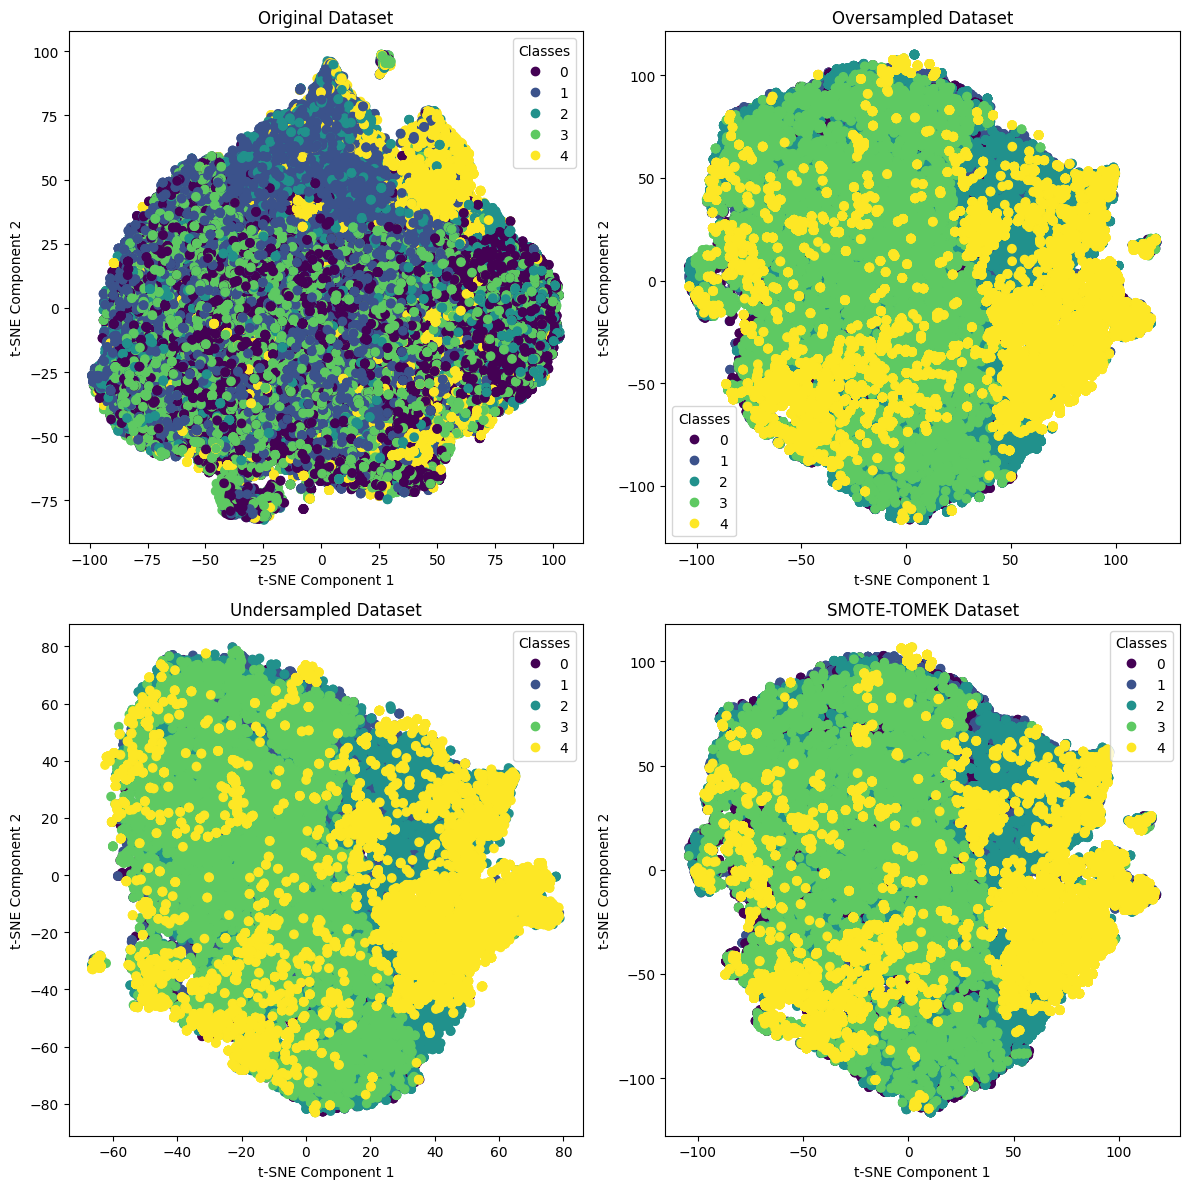

In [48]:
mapping = {'Bicycle': 0, 'Car - Driver': 1, 'Car - Passenger': 2, 'Foot': 3, 'Public Transport': 4}
labels = [mapping[label] for label in mapping]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Original dataset
scatter_original = axs[0, 0].scatter(X_tsne_original[:, 0], X_tsne_original[:, 1], c=y_train_split, cmap='viridis')
axs[0, 0].set_title('Original Dataset')
axs[0, 0].set_xlabel('t-SNE Component 1')
axs[0, 0].set_ylabel('t-SNE Component 2')

# Oversampled dataset
scatter_oversampled = axs[0, 1].scatter(X_tsne_oversampled[:, 0], X_tsne_oversampled[:, 1], c=y_train_oversampled, cmap='viridis')
axs[0, 1].set_title('Oversampled Dataset')
axs[0, 1].set_xlabel('t-SNE Component 1')
axs[0, 1].set_ylabel('t-SNE Component 2')

# Undersampled dataset
scatter_undersampled = axs[1, 0].scatter(X_tsne_undersampled[:, 0], X_tsne_undersampled[:, 1], c=y_train_undersampled, cmap='viridis')
axs[1, 0].set_title('Undersampled Dataset')
axs[1, 0].set_xlabel('t-SNE Component 1')
axs[1, 0].set_ylabel('t-SNE Component 2')

# SMOTE dataset
scatter_smt = axs[1, 1].scatter(X_tsne_smt[:, 0], X_tsne_smt[:, 1], c=y_train_smt, cmap='viridis')
axs[1, 1].set_title('SMOTE-TOMEK Dataset')
axs[1, 1].set_xlabel('t-SNE Component 1')
axs[1, 1].set_ylabel('t-SNE Component 2')

#legends with class labels
legend_original = axs[0, 0].legend(handles=scatter_original.legend_elements()[0], labels=labels, title='Classes')
legend_oversampled = axs[0, 1].legend(handles=scatter_oversampled.legend_elements()[0], labels=labels, title='Classes')
legend_undersampled = axs[1, 0].legend(handles=scatter_undersampled.legend_elements()[0], labels=labels, title='Classes')
legend_smt = axs[1, 1].legend(handles=scatter_smt.legend_elements()[0], labels=labels, title='Classes')

plt.tight_layout()
plt.savefig("tsne_with_legend.png")
plt.show()

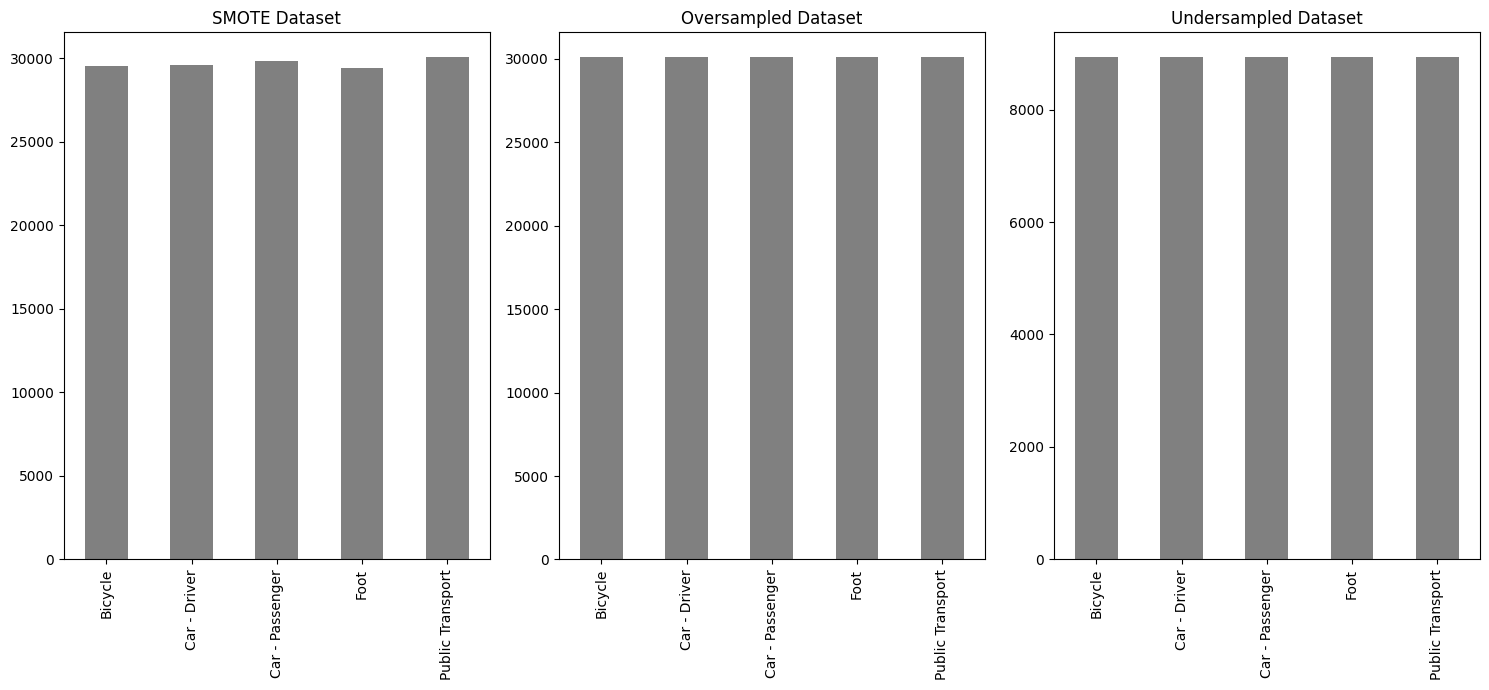

In [40]:
plt.figure(figsize=(15, 7))

plt.subplot(131)
pd.DataFrame(y_train_smt).replace({0: 'Bicycle', 1: 'Car - Driver', 2: 'Car - Passenger', 3: 'Foot',
                                   4: 'Public Transport'}).groupby(0).size().plot(kind="bar",color='gray')
plt.title('SMOTE Dataset')
plt.xlabel('')

plt.subplot(132)
pd.DataFrame(y_train_oversampled).replace({0: 'Bicycle', 1: 'Car - Driver', 2: 'Car - Passenger', 3: 'Foot',
                                           4: 'Public Transport'}).groupby(0).size().plot(kind="bar",color='gray')
plt.title('Oversampled Dataset')
plt.xlabel('')

plt.subplot(133)
pd.DataFrame(y_train_undersampled).replace({0: 'Bicycle', 1: 'Car - Driver', 2: 'Car - Passenger', 3: 'Foot',
                                            4: 'Public Transport'}).groupby(0).size().plot(kind="bar",color='gray')

plt.title('Undersampled Dataset')
plt.xlabel('')

plt.tight_layout()
plt.savefig("distr_bal.png")
plt.show()
